In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import opendatasets as od
AUTOTUNE = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

! pip install tensorflow-addons
import tensorflow_addons as tfa

Number of replicas: 1


/Users/aksharareddypatlannagari/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
#Reading the data
# Directory paths containing TFRecord files for Monet paintings and photos
monet_dir = '/Users/aksharareddypatlannagari/Documents/NEU/classes/Neural networks/gan-getting-started/monet_tfrec/*.tfrec'
photo_dir = '/Users/aksharareddypatlannagari/Documents/NEU/classes/Neural networks/gan-getting-started/photo_tfrec/*.tfrec'

# Get a list of TFRecord files for Monet paintings
monet_paintings = tf.io.gfile.glob(monet_dir)
print('Monet TFRecord Files:', len(monet_paintings))

# Get a list of TFRecord files for photos
photos = tf.io.gfile.glob(photo_dir)
print('Photo TFRecord Files:', len(photos))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [2]:
# Function to read images from a folder and convert to TensorFlow dataset
def read_images_from_folder(folder_path, batch_size):
    # List all files in the folder
    files = tf.data.Dataset.list_files(folder_path + '/*.jpg')

    # Read images from files
    dataset = files.map(lambda x: tf.io.read_file(x))
    
    # Decode JPEG images
    dataset = dataset.map(lambda x: tf.image.decode_jpeg(x, channels=3))
    
    # Normalize pixel values to the range [0, 1]
    dataset = dataset.map(lambda x: (tf.cast(x, tf.float32) / 127.5)-1)
    
    # Create batches
    dataset = dataset.batch(batch_size)

    return dataset

# Set folder path and batch size
folder_path_monet = 'gan-getting-started/monet_jpg'
batch_size = 1

# Set folder path and batch size
folder_path_photo = 'gan-getting-started/photo_jpg'
batch_size = 1

# Create dataset from folder
monet_batch = read_images_from_folder(folder_path_monet, batch_size)
photo_batch = read_images_from_folder(folder_path_photo, batch_size)

# Use next(iter()) to get the next batch
monet_iter = next(iter(monet_batch))
photo_iter = next(iter(photo_batch))

# Print the shape of the batch
print("Batch shape:", monet_iter.shape)
print("Batch shape:", photo_iter.shape)

Batch shape: (1, 256, 256, 3)
Batch shape: (1, 256, 256, 3)


In [12]:
IMAGE_SIZE = [256, 256]



def image_decoder(image):

    # Decode JPEG image
    image = tf.image.decode_jpeg(image, channels=3)

    # Normalize pixel values to range [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    # Resize image to specified dimensions
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image



def tfrecord_reader(example):

    # Define the format of TFRecord entries
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }

    # Parse a single TFRecord entry
    example = tf.io.parse_single_example(example, tfrecord_format)

    # Decode and preprocess the image
    image = image_decoder(example['image'])

    return image



def dataset_loader(filenames, labeled=True, ordered=False):
    
    # Create a TFRecordDataset from given filenames
    dataset = tf.data.TFRecordDataset(filenames)

    # Map parsing function to each TFRecord entry
    dataset = dataset.map(tfrecord_reader, num_parallel_calls=AUTOTUNE)
    
    return dataset

# Load the dataset containing Monet paintings and batch it with a batch size of 1
monet_batch = dataset_loader(monet_paintings, labeled=True).batch(1)
# Load the dataset containing photos and batch it with a batch size of 1
photo_batch = dataset_loader(photos, labeled=True).batch(1)
# Get an iterator for the Monet dataset to access the data batch-wise
monet_iter = next(iter(monet_batch))
# Get an iterator for the photo dataset to access the data batch-wise
photo_iter = next(iter(photo_batch))

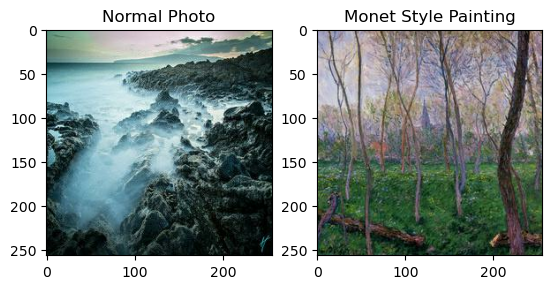

In [3]:
plt.subplot(1,2,1)                                       # creating a subplot with 1 row and 2 columns
plt.title('Normal Photo')
plt.imshow(photo_iter[0]*0.5 +0.5)                         # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Monet Style Painting')
plt.imshow(monet_iter[0]*0.5 +0.5)

This downsampling operation is typically used to gradually reduce the spatial dimensions of the feature maps while increasing the number of channels, allowing the network to learn hierarchical features at different scales.

In [4]:
# OUTPUT_CHANNELS = 3

def downsample_layer(filters, size, apply_instancenorm=True):

    # Initialize the weights of the convolutional layer
    initializer = tf.random_normal_initializer(0., 0.02)

    # Initialize the weights of the InstanceNormalization gamma parameter
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Define a sequential model for down-sampling
    output = keras.Sequential()

    # Add a convolutional layer with specified filters, kernel size, and stride for downsampling
    output.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    # If specified, apply InstanceNormalization
    if apply_instancenorm:
        output.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Add LeakyReLU activation function
    output.add(layers.LeakyReLU())

    return output

Upsampling is a crucial component for generating high-resolution images from low-resolution inputs. 
"upsampling" refers to the process of increasing the spatial dimensions (width and height) of an input feature map.

In [5]:
def upsample_layer(filters, size, apply_dropout=False):

    # Initialize the weights of the convolutional layers
    initializer = tf.random_normal_initializer(0., 0.02)

    # Initialize the gamma parameter for instance normalization
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Create a sequential model to build the upsampling layer
    output = keras.Sequential()

    # Add a transposed convolutional layer for upsampling
    output.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    # Add instance normalization layer to normalize the activations
    output.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # If apply_dropout is True, add a dropout layer to prevent overfitting
    if apply_dropout:
        output.add(layers.Dropout(0.5))

    # Add ReLU activation function to introduce non-linearity
    output.add(layers.ReLU())

    return output

In [6]:
def Generator_Network():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    downsample_stack = [
        downsample_layer(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample_layer(128, 4), # (bs, 64, 64, 128)
        downsample_layer(256, 4), # (bs, 32, 32, 256)
        downsample_layer(512, 4), # (bs, 16, 16, 512)
        downsample_layer(512, 4), # (bs, 8, 8, 512)
        downsample_layer(512, 4), # (bs, 4, 4, 512)
        downsample_layer(512, 4), # (bs, 2, 2, 512)
        downsample_layer(512, 4), # (bs, 1, 1, 512)
    ]

    upsample_stack = [
        upsample_layer(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample_layer(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample_layer(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample_layer(512, 4), # (bs, 16, 16, 1024)
        upsample_layer(256, 4), # (bs, 32, 32, 512)
        upsample_layer(128, 4), # (bs, 64, 64, 256)
        upsample_layer(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in downsample_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(upsample_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [7]:
def Discriminator_Network():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    layer_1 = downsample_layer(64, 4, False)(x) # (bs, 128, 128, 64)
    layer_2 = downsample_layer(128, 4)(layer_1) # (bs, 64, 64, 128)
    layer_3 = downsample_layer(256, 4)(layer_2) # (bs, 32, 32, 256)

    zero_padding_layer = layers.ZeroPadding2D()(layer_3) # (bs, 34, 34, 256)
    convolution_layer_1 = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_padding_layer) # (bs, 31, 31, 512)

    normalization_layer = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(convolution_layer_1)

    activation_layer = layers.LeakyReLU()(normalization_layer)

    zero_padding_layer_2 = layers.ZeroPadding2D()(activation_layer) # (bs, 33, 33, 512)

    output = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_padding_layer_2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=output)

In [8]:

# transforms photos to Monet styled paintings
monet_generator = Generator_Network() 
# transforms Monet paintings to be more like photos
photo_generator = Generator_Network() 
# differentiates between real Monet paintings and generated Monet paintings
monet_discriminator = Discriminator_Network() 
# differentiates between real photos and generated photos
photo_discriminator = Discriminator_Network()

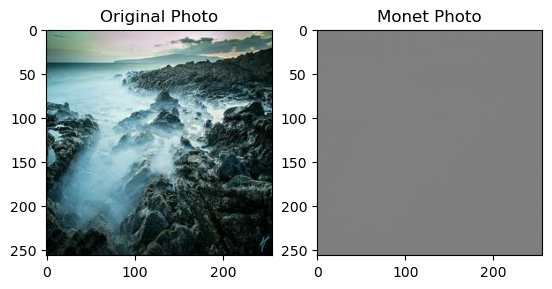

In [9]:
before_training = monet_generator(photo_iter)
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(photo_iter[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet Photo")
plt.imshow(before_training[0] * 0.5 + 0.5)
plt.show()

In [10]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        # Initialize the CycleGAN model with generators, discriminators, and hyperparameters
        self.m_gen = monet_generator # Monet generator
        self.p_gen = photo_generator # Photo generator
        self.m_disc = monet_discriminator # Monet discriminator
        self.p_disc = photo_discriminator # Photo discriminator
        self.lambda_cycle = lambda_cycle # Cycle consistency loss weight
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        # Compile the CycleGAN model with optimizers and loss functions
        self.m_gen_optimizer = m_gen_optimizer # Monet generator optimizer
        self.p_gen_optimizer = p_gen_optimizer # Photo generator optimizer
        self.m_disc_optimizer = m_disc_optimizer # Monet discriminator optimizer
        self.p_disc_optimizer = p_disc_optimizer # Photo discriminator optimizer
        self.gen_loss_fn = gen_loss_fn # Generator loss function
        self.disc_loss_fn = disc_loss_fn # Discriminator loss function
        self.cycle_loss_fn = cycle_loss_fn # Cycle consistency loss function
        self.identity_loss_fn = identity_loss_fn # Identity loss function
        
    def train_step(self, batch_data):
        # Unpack real Monet paintings and real photos from the batch data
        real_monet, real_photo = batch_data
        
        # Use a gradient tape to record operations for automatic differentiation
        with tf.GradientTape(persistent=True) as tape:
            
            # Generate fake Monet paintings from real photos and reconstruct original photos
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Generate fake photos from real Monet paintings and reconstruct original Monet paintings
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generate Monet paintings and photos that are supposed to be the same as the real ones
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminate between real and fake Monet paintings and real and fake photos
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Calculate generator and discriminator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            

        # Compute gradients for generator and discriminator parameters
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients to update generator and discriminator parameters
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        # Return dictionary of losses for monitoring during training
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
    

In [11]:

def discriminator_loss_calc(real, generated):
    # Calculate the binary cross-entropy loss for the real images
    real_discriminator_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    # Calculate the binary cross-entropy loss for the generated (fake) images
    generated_discriminator_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    # Combine the losses from real and generated images
    total_discriminator_loss = real_discriminator_loss + generated_discriminator_loss
    # Scale the total loss by 0.5
    return total_discriminator_loss * 0.5

In [12]:
# Computes the generator loss for a batch of generated images.
def generator_loss_calc(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [13]:
# Calculates the cycle consistency loss between the real and cycled images.
def calc_cycle_loss_calc(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [14]:
# Calculates the identity loss between the real and reconstructed images.
def identity_loss_calc(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [15]:
# Utilizing the Adam optimizer
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:

Cycle_Gan_Model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

Cycle_Gan_Model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss_calc,
    disc_loss_fn = discriminator_loss_calc,
    cycle_loss_fn = calc_cycle_loss_calc,
    identity_loss_fn = identity_loss_calc
)

In [17]:
for monet, photo in tf.data.Dataset.zip((monet_batch, photo_batch)).take(1):
    print("Monet shape:", monet.shape)
    print("Photo shape:", photo.shape)

Monet shape: (1, 256, 256, 3)
Photo shape: (1, 256, 256, 3)


In [21]:
Cycle_Gan_Model.fit(tf.data.Dataset.zip((monet_batch, photo_batch)), epochs=10)

Epoch 1/10
300/300 [==============================] - 911s 3s/step - monet_gen_loss: 2.4510 - photo_gen_loss: 2.5864 - monet_disc_loss: 0.6222 - photo_disc_loss: 0.5929
Epoch 2/10
300/300 [==============================] - 923s 3s/step - monet_gen_loss: 2.4387 - photo_gen_loss: 2.6067 - monet_disc_loss: 0.6148 - photo_disc_loss: 0.5887
Epoch 3/10
300/300 [==============================] - 826s 3s/step - monet_gen_loss: 2.4401 - photo_gen_loss: 2.6493 - monet_disc_loss: 0.6391 - photo_disc_loss: 0.5785
Epoch 4/10
300/300 [==============================] - 765s 3s/step - monet_gen_loss: 2.4504 - photo_gen_loss: 2.6157 - monet_disc_loss: 0.6351 - photo_disc_loss: 0.5914
Epoch 5/10
300/300 [==============================] - 833s 3s/step - monet_gen_loss: 2.3611 - photo_gen_loss: 2.5631 - monet_disc_loss: 0.6490 - photo_disc_loss: 0.5972
Epoch 6/10
300/300 [==============================] - 942s 3s/step - monet_gen_loss: 2.3852 - photo_gen_loss: 2.5507 - monet_disc_loss: 0.6283 - photo_disc

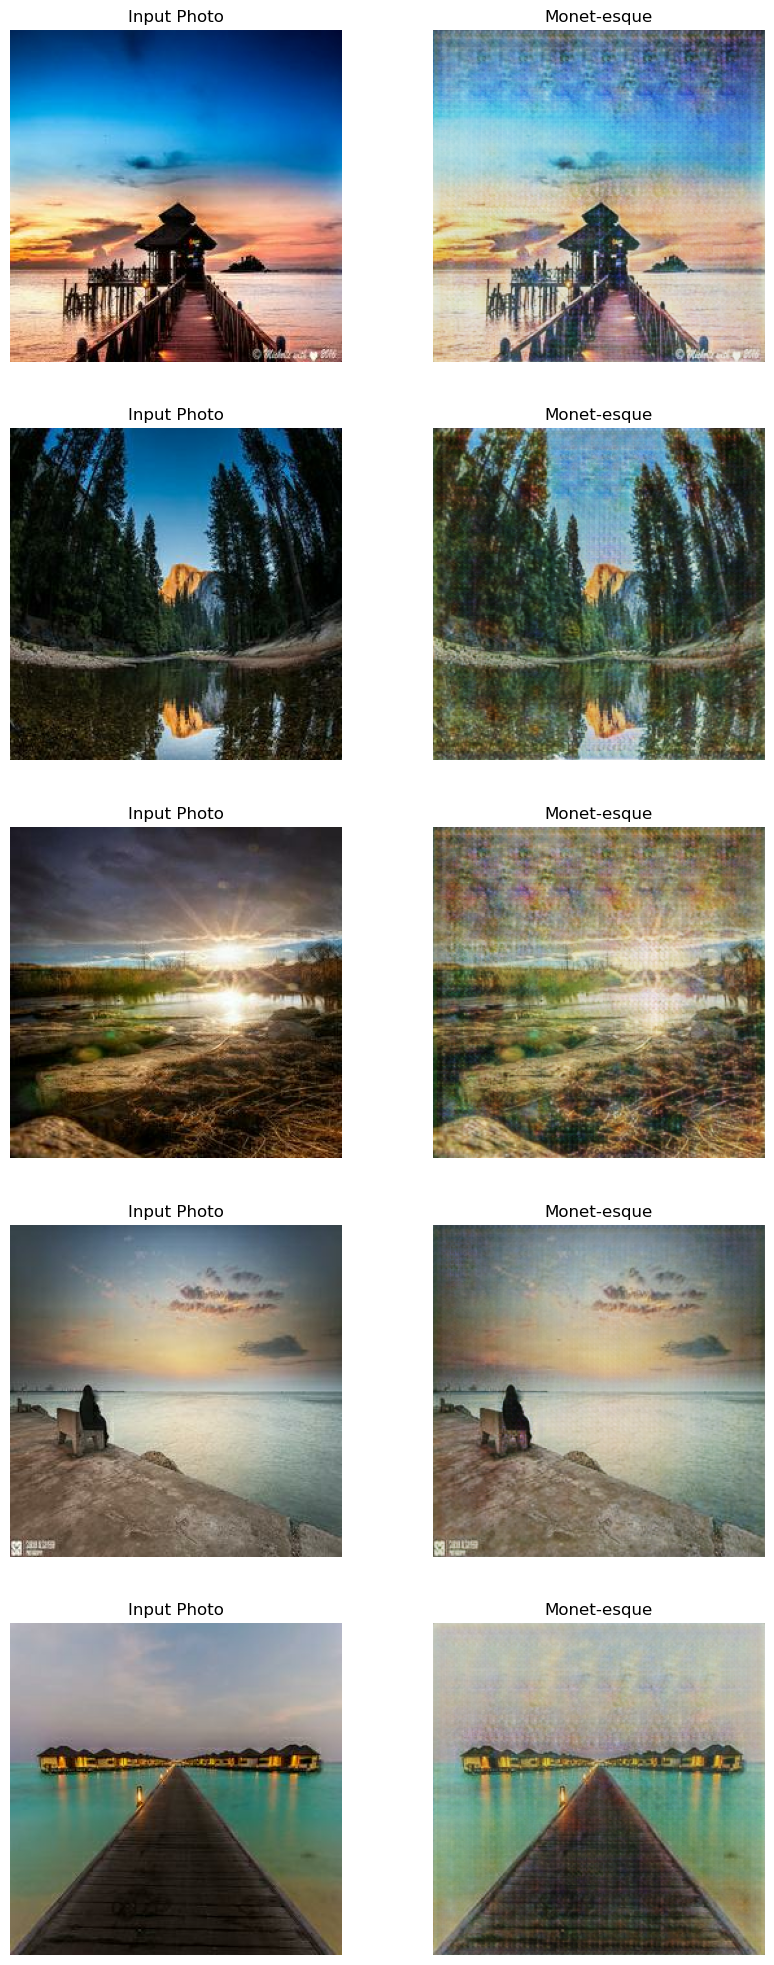

In [22]:
# Displaying the input image and the style converted output of the image
_, ax = plt.subplots(5, 2, figsize=(10, 25))
for i, img in enumerate(photo_batch.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [24]:
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model

In [25]:
def calculate_activation_statistics(images):
    # Resize images to 299x299 as required by InceptionV3
    images_resized = tf.image.resize(images, (299, 299), method=tf.image.ResizeMethod.BICUBIC)
    # Preprocess images for InceptionV3 model
    images_preprocessed = preprocess_input(images_resized)
    # Load InceptionV3 model without classifier layers
    inception_model = InceptionV3(include_top=False, pooling='avg')
    # Extract activations for the input images
    activations = inception_model.predict(images_preprocessed)
    # Calculate mean and covariance of activations
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma

def calculate_fid_score(real_images, fake_images):
    # Compute activation statistics for real and fake images
    mu_real, sigma_real = calculate_activation_statistics(real_images)
    mu_fake, sigma_fake = calculate_activation_statistics(fake_images)
    # Calculate squared difference between means
    diff = mu_real - mu_fake
    # Calculate trace of covariance product
    cov_product = sqrtm(sigma_real.dot(sigma_fake))
    # Calculate FID score
    fid_score = np.dot(diff, diff) + np.trace(sigma_real + sigma_fake - 2*cov_product)
    return fid_score

def calculate_fid_for_cycle_gan(model, monet_dataset, photo_dataset, num_batches=10):
    # Convert datasets to NumPy arrays
    monet_images = np.concatenate([batch.numpy() for batch in monet_dataset.take(num_batches)], axis=0)
    photo_images = np.concatenate([batch.numpy() for batch in photo_dataset.take(num_batches)], axis=0)
    
    # Generate fake Monet paintings from photos
    fake_monet_images = []
    for batch in photo_dataset.take(num_batches):
        fake_monet_batch = model.m_gen(batch, training=False)
        fake_monet_images.append(fake_monet_batch)
    fake_monet_images = tf.concat(fake_monet_images, axis=0)
    
    # Generate fake photos from Monet paintings
    fake_photo_images = []
    for batch in monet_dataset.take(num_batches):
        fake_photo_batch = model.p_gen(batch, training=False)
        fake_photo_images.append(fake_photo_batch)
    fake_photo_images = tf.concat(fake_photo_images, axis=0)
    
    # Compute FID score for Monet paintings
    fid_monet_score = calculate_fid_score(monet_images, fake_monet_images.numpy())
    
    # Compute FID score for photos
    fid_photo_score = calculate_fid_score(photo_images, fake_photo_images.numpy())
    
    return fid_monet_score, fid_photo_score

# Assuming you have already defined monet_batch and photo_batch

# Calculate FID score for the trained CycleGAN model
fid_monet, fid_photo = calculate_fid_for_cycle_gan(Cycle_Gan_Model, monet_batch, photo_batch)

1/1 [==============================] - 2s 2s/step


In [26]:
print("FID score for Monet paintings:", fid_monet.real)
print("FID score for photos:", fid_photo.real)

FID score for Monet paintings: 8.355270526233888
FID score for photos: 20.43530712788141


In [32]:
iterations = 10
monet_gen_losses = []
photo_gen_losses = []
monet_disc_losses = []
photo_disc_losses = []
for i in range(iterations):
    monet_gen_losses.append(np.mean(Cycle_Gan_Model.history.history['monet_gen_loss'][i].reshape(-1))-1)
    photo_gen_losses.append(np.mean(Cycle_Gan_Model.history.history['photo_gen_loss'][i].reshape(-1))-1)
    monet_disc_losses.append(np.mean(Cycle_Gan_Model.history.history['monet_disc_loss'][i].reshape(-1))-1)
    photo_disc_losses.append(np.mean(Cycle_Gan_Model.history.history['photo_disc_loss'][i].reshape(-1))-1)

In [33]:
monet_gen_losses

[2.6466426849365234,
 1.904386043548584,
 1.189028263092041,
 1.2679836750030518,
 1.401017189025879,
 1.4013748168945312,
 0.7832562923431396,
 0.877709150314331,
 1.2697250843048096,
 1.3029592037200928]

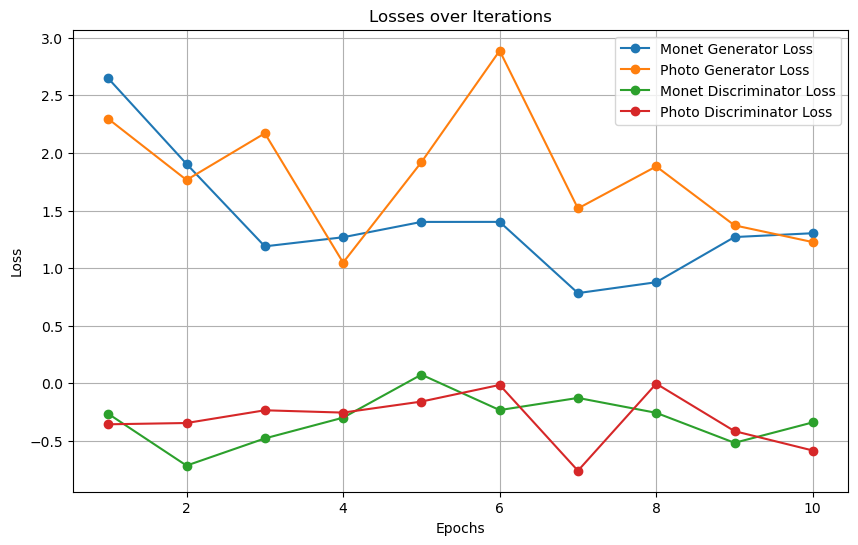

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(range(1,iterations+1), monet_gen_losses, label='Monet Generator Loss', marker='o')

plt.plot(range(1,iterations+1), photo_gen_losses, label='Photo Generator Loss', marker='o')

plt.plot(range(1,iterations+1), monet_disc_losses, label='Monet Discriminator Loss', marker='o')

plt.plot(range(1,iterations+1), photo_disc_losses, label='Photo Discriminator Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()